# Hierarchical Prototypes for Deep Learning
In this notebook, we briefly show the results listed in our paper. 

## Importing and getting everything ready

In [1]:
import os, sys
sys.path.append('src')

In [2]:
import numpy as np
import warnings
import time
import torch 
import argparse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.preprocessing import batch_elastic_transform
from src.train import train_MNIST, load_and_test

In [3]:
# Set device in case of training
# Turn off warnings for loading model
device = torch.device('cpu')
warnings.filterwarnings('ignore')

In [4]:
# load fully trained models
hierarchy_model_path = './Pre-trainedModels/hierarchy_model.pth'
standard_model_path = './Pre-trainedModels/standard_model.pth'

hierarchy_model = torch.load(hierarchy_model_path, map_location=torch.device(device))
standard_model = torch.load(standard_model_path, map_location=torch.device(device))
hierarchy_model.eval()
standard_model.eval()

PrototypeModel(
  (encoder): ConvEncoder(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Sigmoid()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Sigmoid()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): Sigmoid()
      (6): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): Sigmoid()
    )
  )
  (decoder): ConvDecoder(
    (de1): ConvTranspose2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (de2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (de3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (de4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (sigmoid): Sigmoid()
  )
  (prototype): PrototypeClassifier(
    (linear1): Linear(in_features=15, out_features=10, bias=True)
  )
)

### Define function for visualization

In [5]:
def show_prototypes(prototype_set, **kwargs):
    """
    input: numpy set of prototypes
    displays all the prototypes in the input
    """
    fig, ax = plt.subplots(len(prototype_set)//5 ,5)
    col = 0
    for i, img in enumerate(prototype_set):
        if i % 5 == 0 and i != 0:
            col += 1
        ax[col,i%5].imshow(img[0], cmap='gray')

# Nonhierarchical model
This is to reproduce the author's original model.

### Prototype results

In [6]:
# Fetch and convert prototypes
standard_prototypes = standard_model.prototype.get_prototypes()
standard_prototype_img = standard_model.decoder(standard_prototypes.view(-1, 10, 2, 2))

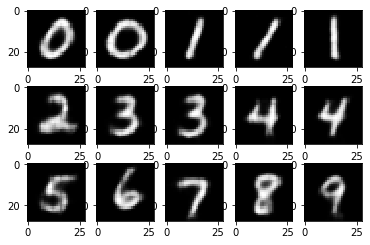

In [7]:
# Get a numerical representation of our prototypes
_, decoding, (r_1, r_2, c) = standard_model(standard_prototype_img)
pred = torch.argmax(c, dim=1)
# Sort the images in accending order
merged = zip(pred, standard_prototype_img.cpu().detach().numpy())
mergedlist = list(merged)
mergedlist.sort(key=lambda x: x[0])
imgs = np.array([x[1] for x in mergedlist])
# display prototypes
show_prototypes(imgs)

### Weight matrix
Below, the prototype images can be seen, followed by the argmin (maximum activation) of the weight matrix and the actual weights.

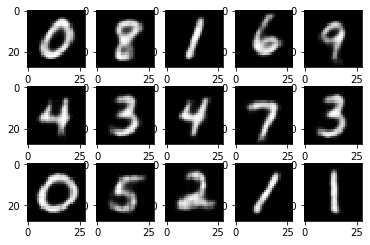

In [8]:
show_prototypes(standard_prototype_img.cpu().detach().numpy())

In [9]:
# Weight matrices
learned_weights = standard_model.prototype.linear1.weight.cpu().detach().numpy().T
print("Maximum weights per column correspond to qualitative prototypes!")
print(learned_weights.argmin(axis=1).reshape(3,5))

print("---")
print("Actual weights")
print(np.array_str(learned_weights, precision=3, suppress_small=True))


Maximum weights per column correspond to qualitative prototypes!
[[0 8 1 6 9]
 [4 3 4 7 3]
 [0 5 2 1 1]]
---
Actual weights
[[-4.893  1.006 -1.257  0.786  0.942  1.301 -0.519  0.99  -0.06  -0.614]
 [-0.43   1.333 -0.271  0.754  0.907  0.831  0.438  0.691 -6.1    0.187]
 [ 0.112 -4.833 -0.386  0.193 -0.111  0.344  0.353  0.298 -0.025  1.04 ]
 [-0.298  0.417  0.465 -0.302 -0.369 -0.593 -6.017  0.898 -0.022  0.992]
 [ 0.711  0.408  0.428  0.165 -0.79   1.09   1.466 -0.319  0.403 -5.515]
 [ 0.423 -0.107  0.254  0.854 -4.368 -0.028  0.431 -0.467  1.027 -0.891]
 [ 0.882  0.609 -0.483 -4.13   1.03  -0.597  0.317  0.349  0.059  0.602]
 [ 0.56   1.066  0.791  1.05  -3.25   0.473 -0.744  0.438 -1.158 -0.379]
 [ 0.348 -0.395  0.747 -0.086  0.527  0.108  1.426 -5.667  0.724  0.045]
 [ 0.872  0.488  0.957 -3.491  0.764 -0.973  1.014  0.429  0.208 -1.63 ]
 [-3.358  0.613  0.393  0.991  0.728 -0.953 -0.68  -0.344  1.028 -0.044]
 [ 0.496  0.332  0.902 -0.286  0.681 -5.046 -0.668  0.59   0.418  0.399]


## Test Model

In [10]:
load_and_test(standard_model_path, hierarchical = False)

Testdata loss: 4.02052937746048 acc: 0.9878999999999998 sub acc: 0.0


# Hierarchical model

### Prototype results

In [11]:
prototypes = hierarchy_model.prototype.get_prototypes()
sub_prototypes = hierarchy_model.prototype.get_sub_prototypes()

In [12]:
# convert the prototypes
prototype_img = hierarchy_model.decoder(prototypes.view(-1, 10, 2, 2))
sub_prototype_img = hierarchy_model.decoder(sub_prototypes.view(-1, 10, 2, 2))

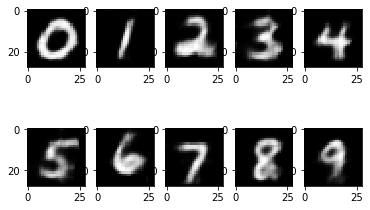

In [13]:
# show prototypes
show_prototypes(prototype_img.cpu().detach().numpy())

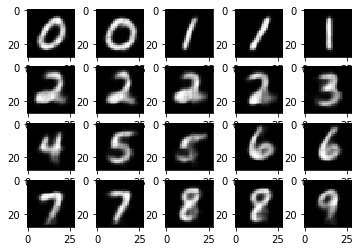

In [14]:
# Get numerical representation of our prototypes
_, decoding, (sub_c, sup_c, r1, r2, r3, r4)  = hierarchy_model(sub_prototype_img)
pred = torch.argmax(sub_c, dim=1)
# Sort the prototypes in asccending order
merged = zip(pred, sub_prototype_img.cpu().detach().numpy())
mergedlist = list(merged)
mergedlist.sort(key=lambda x: x[0])
imgs = np.array([x[1] for x in mergedlist])
# Display prototypes
show_prototypes(imgs)

### Weight matrix for subprototypes
This is the weight matrix that is also shown in the appendix of the paper.

These prototypes correspond to the weight matrix below!


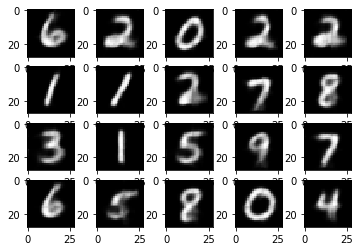

In [15]:
print("These prototypes correspond to the weight matrix below!")
show_prototypes(sub_prototype_img.cpu().detach().numpy())

In [16]:
# Weight matrices
learned_weights = hierarchy_model.prototype.linear2.weight.cpu().detach().numpy().T
print("Maximum weights per column (roughly) correspond to qualitative prototypes")
print(learned_weights.argmin(axis=1).reshape(4,5))

print("---")
print("Actual weights")
print(np.array_str(learned_weights, precision=3, suppress_small=True))


Maximum weights per column (roughly) correspond to qualitative prototypes
[[6 2 0 2 1]
 [1 1 7 7 8]
 [3 1 5 9 7]
 [6 5 8 0 4]]
---
Actual weights
[[-0.016  0.47   0.413 -0.069 -0.155  0.311 -0.859 -0.519  0.035  0.356]
 [ 0.293 -0.118 -0.708  0.183 -0.538  0.206  0.491  0.046 -0.068 -0.417]
 [-1.443  0.313 -0.028 -0.107  0.302  0.086 -0.278  0.504 -0.121 -0.14 ]
 [ 0.267 -0.306 -0.82  -0.321  0.227  0.122 -0.094  0.762  0.657 -0.604]
 [ 0.106 -0.266 -0.193  0.322 -0.262 -0.206  0.027 -0.04  -0.012  0.678]
 [-0.189 -0.509 -0.047  0.213  0.412  0.122 -0.002 -0.327  0.276  0.433]
 [ 0.152 -0.939  0.109 -0.334 -0.376  0.067  0.507  0.221 -0.156  0.473]
 [ 0.019 -0.044 -0.261  0.441  0.392 -0.208 -0.382 -0.399 -0.148  0.329]
 [-0.1   -0.117  0.29  -0.313  0.237 -0.3   -0.001 -0.576  0.533 -0.204]
 [ 0.082  0.458  0.147 -0.351  0.495 -0.223  0.109  0.021 -0.757 -0.128]
 [ 0.113 -0.025  0.48  -2.275  0.023  0.237  0.29   0.086  0.255  0.39 ]
 [ 0.227 -0.722  0.142  0.234  0.212  0.411  0.173 

### Test model

In [17]:
load_and_test(hierarchy_model_path, hierarchical = True)

Testdata loss: 6.474337303638459 acc: 0.9885999999999997 sub acc: 0.9902


# Training example
This code runs the hierarchical prototype network with default parameters as used in our paper. Prototype image results are saved in a separate directory. 

In [18]:
# Global parameters for device and reproducibility
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hierarchical = True
# Globals
learning_rate = 0.0001
training_epochs = 1500
batch_size = 250

sigma = 4
alpha = 20
n_prototypes = 10
n_sub_prototypes = 20
latent_size = 40
n_classes = 10
save_every = 1
underrepresented_class = -1

lambda_dict = { 
    'lambda_class' : 20, 
    'lambda_class_sup' : 20,
    'lambda_class_sub' : 20,
    'lambda_ae' : 1,
    'lambda_r1' : 1,
    'lambda_r2' : 1,
    'lambda_r3' : 1,
    'lambda_r4' : 1
}

result_directory = './notebook_results'

In [19]:
"""
Args:
    Input:
      Model parameters
        hierarchical : Boolean: Is the model hierarchical?
        n_prototypes : The amount of prototypes. When hierarchical is set to true, this is the amount of superprototypes.
        n_sub_prototypes : The amount of subprototypes. Will be ignored if hierarchical is set to false.
        latent_size : Size of the latent space
        n_classes : Amount of classes 
        lambda_dict : Dictionary containing all necessary lambda's for the weighted loss equation
      Training parameters
        learning_rate : 
        training_epochs : 
        batch_size : 
        save_every : how often to save images and models?
      Miscellaneous
        sigma, alpha : Parameters for elastic deformation. Only used for train data
        directory : Directory to save results, prototype images and final model.
        underrepresented  : The class that is to be downsampled (0.25 to 1 for all other classes)
                    When it is set to -1, no class is downsampled.
"""
train_MNIST(
    hierarchical, 
    n_prototypes, 
    n_sub_prototypes, 
    latent_size, 
    n_classes, 
    lambda_dict, 
    learning_rate, 
    training_epochs, 
    batch_size, 
    save_every, 
    sigma, 
    alpha, 
    seed, 
    result_directory,
    underrepresented_class)

Epoch: 0 loss: 122.2045150121053 accuracy: 0.09914999999999988 sub_accuracy: 0.09914999999999992
Epoch: 1 loss: 114.61796674728393 accuracy: 0.10609999999999987 sub_accuracy: 0.1065833333333333
Epoch: 2 loss: 113.32736460367839 accuracy: 0.11041666666666657 sub_accuracy: 0.1126833333333333
Epoch: 3 loss: 112.25967413584391 accuracy: 0.12724999999999984 sub_accuracy: 0.11578333333333332
Epoch: 4 loss: 110.47940063476562 accuracy: 0.2113 sub_accuracy: 0.12753333333333333
Epoch: 5 loss: 104.790944258372 accuracy: 0.3908000000000002 sub_accuracy: 0.20611666666666675
Epoch: 6 loss: 95.23509092330933 accuracy: 0.48506666666666665 sub_accuracy: 0.313066666666667
Epoch: 7 loss: 86.81917883555094 accuracy: 0.5444666666666663 sub_accuracy: 0.39573333333333344
Epoch: 8 loss: 79.7516915957133 accuracy: 0.59385 sub_accuracy: 0.4638666666666665
Epoch: 9 loss: 73.5250139872233 accuracy: 0.6319333333333329 sub_accuracy: 0.5353833333333327
Epoch: 10 loss: 68.27051798502605 accuracy: 0.6661999999999996 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/e/anaconda3/envs/prototype/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-eee942020176>", line 37, in <module>
    underrepresented_class)
  File "/home/e/Desktop/FACT-AI/reports/PrototypeDL/src/train.py", line 295, in train_MNIST
    lambda_dict)
  File "/home/e/Desktop/FACT-AI/reports/PrototypeDL/src/train.py", line 124, in run_epoch
    optimizer.zero_grad()
  File "/home/e/anaconda3/envs/prototype/lib/python3.7/site-packages/torch/optim/optimizer.py", line 165, in zero_grad
    p.grad.zero_()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/e/anaconda3/envs/prototype/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' ob

KeyboardInterrupt: 